In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38149")
client

<Client: 'tcp://127.0.0.1:38149' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from xgcm.grid import Grid
import xrft

import gcm_filters

import seaborn as sns

import os.path as op

# from xeofs.models import EOF
# from pydmd import DMD, BOPDMD, MrDMD
from pydmd.mrcosts import mrCOSTS
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_eigs, plot_summary

from matplotlib import ticker
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ddir = '/tank/spectre/tuchida/Lagrag-filter'

In [5]:
ds = xr.open_dataset(op.join(ddir,'unfilt_u_v_ssh_sst.nc')
                    ).chunk({'time':1})
ds = ds.assign_coords({'j_g':ds.j.data,'i_g':ds.i.data}
                     )
ds

<xarray.Dataset>
Dimensions:         (time: 70, i: 2160, j: 2160, j_g: 2160, i_g: 2160)
Coordinates: (12/23)
  * time            (time) timedelta64[ns] 4 days 18:00:00 ... 73 days 18:00:00
  * i               (i) int64 1080 1081 1082 1083 1084 ... 3236 3237 3238 3239
  * j               (j) float64 0.0 1.0 2.0 ... 2.157e+03 2.158e+03 2.159e+03
    x0              (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0              (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0              float64 ...
    ...              ...
    YC              (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    XG              (j_g, i_g) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    YG              (j_g, i_g) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    RAC             (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
  * j_g             (j_g) float64 0.0 1.0 2.0 ... 2.157e+03 2.158e+03 2.159e+03
  * i_g             (i_g) int64 1080 1081 1082 1083 1084 ... 3236 3237 3238 3239
Data variables:
    u_unfiltered    (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    v_unfiltered    (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    ssh_unfiltered  (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    Theta           (time, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
Attributes:
    title:        70 days of daily surface velocity, SST and steric ssh, unfi...
    institution:  LDEO
    source:       MITgcm LLC4320
    history:      This version created 2022-05-20 by C. Spencer Jones
    references:   Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. S...

In [79]:
ds0 = xr.open_dataset(op.join(ddir,'filt_u_v_ssh.nc'))
ds0 = ds0.assign_coords({'j_g':ds0.j.data,'i_g':ds0.i.data}
                     )
ds0

<xarray.Dataset>
Dimensions:       (i: 2160, j: 2160, time: 70, j_g: 2160, i_g: 2160)
Coordinates: (12/21)
  * i             (i) int64 1080 1081 1082 1083 1084 ... 3236 3237 3238 3239
  * j             (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
  * time          (time) int64 0 86400 172800 259200 ... 5788800 5875200 5961600
    x0            (i) float64 ...
    y0            (j) float64 ...
    z0            float64 ...
    ...            ...
    YC            (j, i) float32 ...
    XG            (j_g, i_g) float32 ...
    YG            (j_g, i_g) float32 ...
    RAC           (j, i) float32 ...
  * j_g           (j_g) float64 0.0 1.0 2.0 ... 2.157e+03 2.158e+03 2.159e+03
  * i_g           (i_g) int64 1080 1081 1082 1083 1084 ... 3236 3237 3238 3239
Data variables:
    u_filtered    (time, i, j) float32 ...
    v_filtered    (time, i, j) float32 ...
    ssh_filtered  (time, i, j) float32 ...
Attributes:
    title:        70 days of daily surface velocity and steric ssh, Lagrangia...
    institution:  LDEO
    source:       MITgcm LLC4320, with filtering methods applied to some of t...
    history:      This version created 2022-05-20 by C. Spencer Jones
    references:   Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. S...

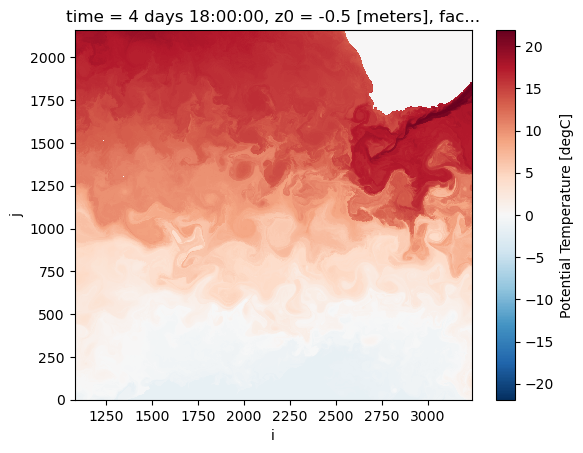

In [15]:
ds.Theta.isel(time=0).plot(rasterized=True)

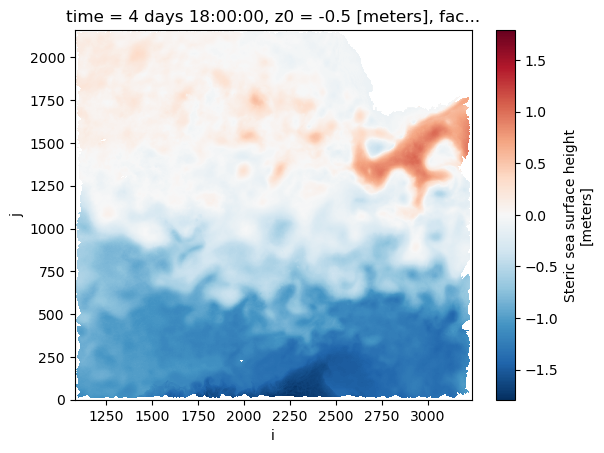

In [16]:
ds.ssh_unfiltered.isel(time=0).T.plot(rasterized=True)

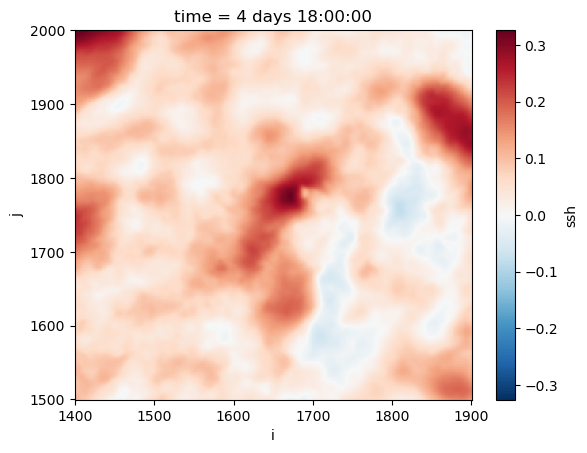

In [7]:
fscale = 15
reg = 2
jjs,jje = (1500,2000)
iis,iie = (1400,1900)
dsm = xr.open_zarr(op.join(ddir,'SSH_%02dkm.zarr' % fscale))
dsm.ssh.isel(time=0).sel(j=slice(jjs,jje),i=slice(iis,iie)
                        ).plot(rasterized=True)

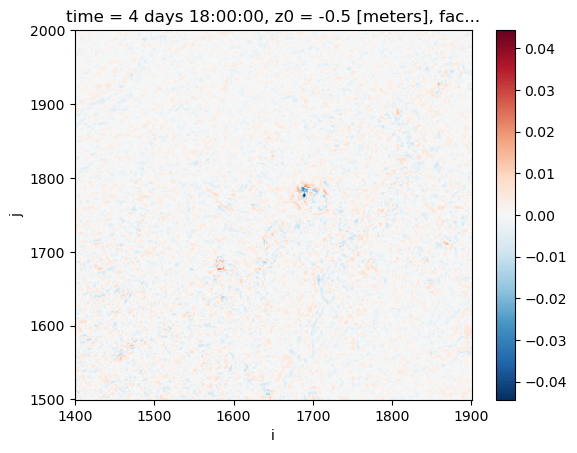

In [7]:
(-dsm.ssh + ds.ssh_unfiltered
).isel(time=0).sel(j=slice(jjs,jje),i=slice(iis,iie)
                  ).plot(rasterized=True)

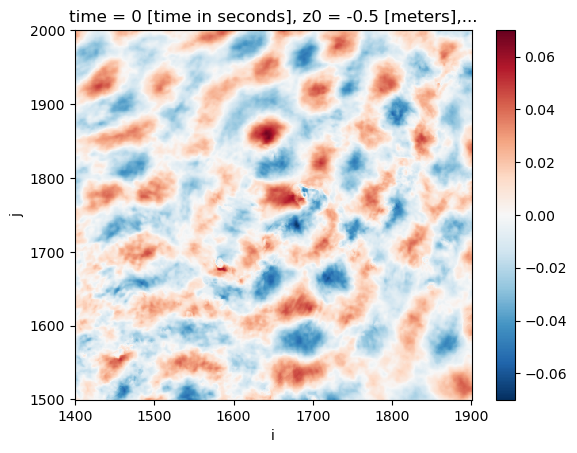

In [8]:
(-ds0.ssh_filtered + ds.ssh_unfiltered.data
).isel(time=0).sel(j=slice(jjs,jje),i=slice(iis,iie)
                  ).T.plot(rasterized=True)

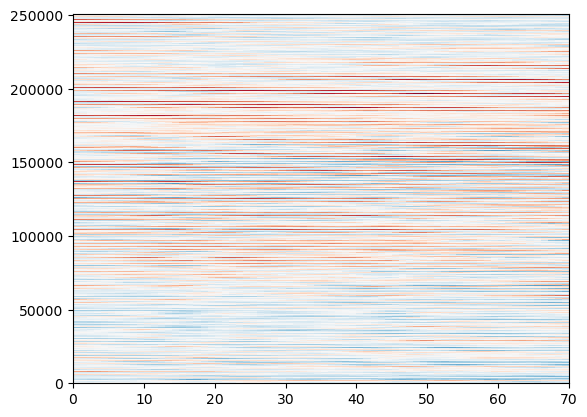

<xarray.DataArray 'ssh_unfiltered' (z: 251001, time: 70)>
dask.array<transpose, shape=(251001, 70), dtype=float32, chunksize=(1750, 1), chunktype=numpy.ndarray>
Coordinates: (12/16)
    x0       (z) float64 dask.array<chunksize=(1750,), meta=np.ndarray>
    y0       (z) float64 dask.array<chunksize=(1750,), meta=np.ndarray>
    z0       float64 ...
    face     int64 ...
    x        (z) float32 dask.array<chunksize=(1750,), meta=np.ndarray>
    y        (z) float32 dask.array<chunksize=(1750,), meta=np.ndarray>
    ...       ...
    YC       (z) float32 dask.array<chunksize=(1750,), meta=np.ndarray>
    RAC      (z) float32 dask.array<chunksize=(1750,), meta=np.ndarray>
  * z        (z) object MultiIndex
  * j        (z) float64 1.5e+03 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * i        (z) int64 1400 1401 1402 1403 1404 ... 1896 1897 1898 1899 1900
  * time     (time) float64 0.0 8.64e+04 1.728e+05 ... 5.875e+06 5.962e+06
Attributes:
    units:      meters
    long_name:  Steric sea surface height

In [8]:
zchunk = 1750
# h_stacked = SSH.stack(z=("lat","lon")).chunk({'z':zchunk})
ssha_m = dsm.ssh.sel(j=slice(jjs,jje),i=slice(iis,iie)
                       ).interpolate_na(dim='i'
                                       ).interpolate_na(dim='j'
                                                       )
ssha_m -= ssha_m.mean(['j','i'])
# h_stacked = ssha.stack(z=("j","i")
#                    ).chunk({'z':zchunk}
#                           ).assign_coords({'time':np.arange(len(ds.time)
#                                                            )*24.*3600.})
ssha = ds.ssh_unfiltered.sel(j=slice(jjs,jje),i=slice(iis,iie)
                       ).interpolate_na(dim='i'
                                       ).interpolate_na(dim='j'
                                                       ).transpose('time','j','i')
ssha -= ssha.mean(['j','i'])
h_stacked = ssha.stack(z=("j","i")
                   ).chunk({'z':zchunk}
                          ).assign_coords({'time':np.arange(len(ds.time)
                                                           )*24.*3600.})
# t_stacked = SST.stack(z=("lat","lon")).chunk({'z':zchunk})
# s_stacked = SSS.stack(z=("lat","lon")).chunk({'z':zchunk})
# u_stacked = hycom01s.uu1.stack(z=("lat","lon")).chunk({'z':zchunk})
# v_stacked = hycom01s.vv1.stack(z=("lat","lon")).chunk({'z':zchunk})
# hts = xr.concat([xr.concat([h_stacked.drop("z")/ampH, 
#                             t_stacked.drop("z")/ampT
#                            ], dim="z"), 
#                  s_stacked.drop("z")/ampS
#                 ], dim='z')

fig, ax = plt.subplots()
ax.pcolormesh(h_stacked.T.values, 
              rasterized=True, vmax=.3, vmin=-.3, cmap='RdBu_r'
             )
plt.show()
h_stacked.T

In [9]:
nh = 24
window_lengths = (np.array([168, 192, 240, 720]) / nh).astype(int)            # 24 hourly, 4 layers
step_sizes = np.array([1, 1, 1, 1])
# window_lengths = (np.array([144, 168, 192, 240, 720]) / nh).astype(int)       # 24 hourly, 5 layers
# step_sizes = np.array([1, 1, 1, 1, 1])
# window_lengths = (np.array([144, 168, 192, 216, 240, 720]) / nh).astype(int)  # 24 hourly, 6layers
# step_sizes = np.array([1, 1, 1, 1, 1, 1])
print(window_lengths, 
      window_lengths*(nh*3600)/86400, '[days]')

[ 7  8 10 30] [ 7.  8. 10. 30.] [days]


In [10]:
fit = False

In [12]:
svd_ranks = [4, 4, 6, 12]
suppress_growth = True
transform_method = "absolute"
# n_components_array = [2] * len(window_lengths)
global_svd_array = [False] * len(window_lengths)

dmd = mrCOSTS(
    svd_rank_array=svd_ranks,
    window_length_array=window_lengths,
    step_size_array=step_sizes,
    global_svd_array=global_svd_array,
    cluster_sweep=True,
    transform_method=transform_method,
    # pydmd_kwargs={'eig_constraints':{"imag", "conjugate_pairs"}},
    # n_components_array=n_components_array,
)

if fit:
    dmd.fit(h_stacked.values.T, 
            np.atleast_2d(h_stacked.time.data)
           )

_________________________________________________
Fitting window length = 7
0 of 64
50 of 64
Error in Global Reconstruction = 0.041
_________________________________________________
Fitting window length = 8
0 of 63
50 of 63
Error in Global Reconstruction = 0.025
_________________________________________________
Fitting window length = 10
0 of 61
50 of 61
Error in Global Reconstruction = 0.024
_________________________________________________
Fitting window length = 30
0 of 41
Error in Global Reconstruction = 0.067


In [11]:
if fit:
    dmd.to_netcdf(op.join(ddir, 
                          "llc4320/mrCOSTS_h/%02dhourly/reg%02d/%02d_fit_new"
                          % (nh,reg,len(window_lengths))
                         )
                 )
else:
    import glob

    mrc = glob.glob(op.join(ddir, 
                            "llc4320/mrCOSTS_h/%02dhourly/reg%02d/%02d_fit_new*.nc"
                            % (nh,reg,len(window_lengths))
                           )
                   )
    print(mrc)
    dmd = mrCOSTS()
    dmd.from_netcdf(mrc)

['/tank/spectre/tuchida/Lagrag-filter/llc4320/mrCOSTS_h/24hourly/reg02/04_fit_new.window=10.nc', '/tank/spectre/tuchida/Lagrag-filter/llc4320/mrCOSTS_h/24hourly/reg02/04_fit_new.window=8.nc', '/tank/spectre/tuchida/Lagrag-filter/llc4320/mrCOSTS_h/24hourly/reg02/04_fit_new.window=7.nc', '/tank/spectre/tuchida/Lagrag-filter/llc4320/mrCOSTS_h/24hourly/reg02/04_fit_new.window=30.nc']


In [12]:
dmd.multi_res_interp()
dmd._da_omega

<xarray.DataArray 'omega' (window_length: 4, window_time_means: 64, svd_rank: 12)>
array([[[            nan           +nanj,
                     nan           +nanj,
         -1.64868331e-06+2.04769754e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -1.73409612e-06+2.03906411e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
         -1.81992585e-06+2.02742710e-05j, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        ...,
        [            nan           +nanj,
...
                     nan           +nanj],
        ...,
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj],
        [            nan           +nanj,
                     nan           +nanj,
                     nan           +nanj, ...,
                     nan           +nanj,
                     nan           +nanj,
                     nan           +nanj]]])
Coordinates:
  * window_time_means    (window_time_means) float64 2.592e+05 ... 5.702e+06
  * svd_rank             (svd_rank) int64 0 1 2 3 4 5 6 7 8 9 10 11
    slide                (window_length, window_time_means) int64 0 1 ... 40 40
  * window_length        (window_length) int64 7 8 10 30
    decomposition_level  (window_length) int64 0 1 2 3

fitting n_components = 6
fitting n_components = 7
fitting n_components = 8
fitting n_components = 9
fitting n_components = 10
fitting n_components = 11
fitting n_components = 12
fitting n_components = 13
fitting n_components = 14
fitting n_components = 15
fitting n_components = 16
fitting n_components = 17
fitting n_components = 18
fitting n_components = 19
fitting n_components = 20
fitting n_components = 21
fitting n_components = 22
fitting n_components = 23
fitting n_components = 24
fitting n_components = 25
Optimal silhouette score is = 15


Text(0, 0.5, 'Silhouette score (-), (1 is best, -1 is worst)')

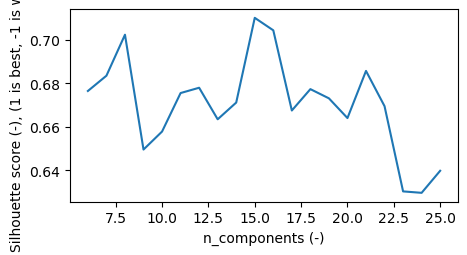

In [13]:
n_components_range = np.arange(6, 26)
scores, n_optimal = dmd.global_cluster_hyperparameter_sweep(
    n_components_range,
    transform_method="log10",
)

print("Optimal silhouette score is = {}".format(n_optimal))
plt.figure(figsize=(5, 2.5))
plt.plot(n_components_range, scores)
plt.gca().set_xlabel("n_components (-)")
plt.gca().set_ylabel("Silhouette score (-), (1 is best, -1 is worst)")

In [14]:
cluster_centroids, omega_classes, omega_array = dmd.global_cluster_omega(
    n_optimal, transform_method="log10"
)
cluster_centers_periods = 1 / (10 ** (cluster_centroids) / (2 * np.pi))

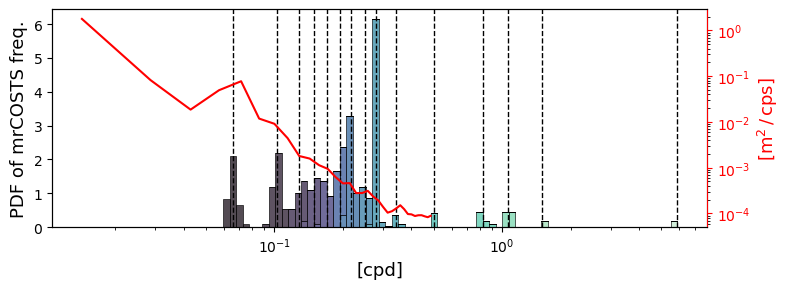

In [15]:
x_trans = (2 * np.pi / 10**omega_array / 86400.)**-1

hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
cluster_centers = 1 / ((10 ** cluster_centroids) / (2 * np.pi) / 86400.)

# Make a continuous color palette with the brightest and darkest excluded
palette = sns.color_palette("mako", len(cluster_centers) + 2)
# palette = palette[1:-1]

ssh = dsm.ssh.sel(j=slice(jjs,jje),i=slice(iis,iie)
                 )
Fh = xrft.power_spectrum(ssh.isel(j=np.arange(0,len(ssh.j),48),
                                  i=np.arange(0,len(ssh.i),48)
                                 ).chunk({'time':-1}
                                        ).assign_coords({'time':np.arange(len(dsm.time)
                                                                         ) 
                                                         * nh*3600.}), 
                         dim='time', window='hann', window_correction=True
                        ).astype(np.single)

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
fig.set_tight_layout(True)

ax2.plot(Fh.freq_time.isel(freq_time=slice(len(Fh.freq_time)//2+1,None))*86400, 
        Fh.isel(freq_time=slice(len(Fh.freq_time)//2+1,None)
               ).mean(['j','i'])*2 * 1e-4, 
        c='r', label=r"Fourier")

ax.set_xscale("log")
ax2.set_yscale("log")

sns.histplot(
    # x=((10**omega_array) / (2 * np.pi) / 86400.),
    x=x_trans,
    hue=omega_classes,
    hue_order=hue_order,
    common_bins=True,
    common_norm=True,
    stat="density",
    multiple="stack",
    bins=70,
    palette=ListedColormap(palette),
    legend=False,
    ax=ax
)

ax.set_xlabel(r"[cpd]", fontsize=13)
ax.set_ylabel("PDF of mrCOSTS freq.", fontsize=13)
ax2.set_ylabel("[m$^2\,/\,$cps]", fontsize=13, c='r')

ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')

[
    ax.axvline((2 * np.pi / (10**c) / 86400)**-1, color="k", ls="--", lw=1)
    for nc, c in enumerate(cluster_centroids)
];

# plt.savefig(op.join(ddir,'Figs/llc4320_mrCOSTS_hist_%02dh-reg%02d-%02d.pdf' 
#                     % (nh,reg,len(window_lengths)))
#            )

In [16]:
omega_classes_list = dmd.multi_res_deterp()

In [17]:
save = False

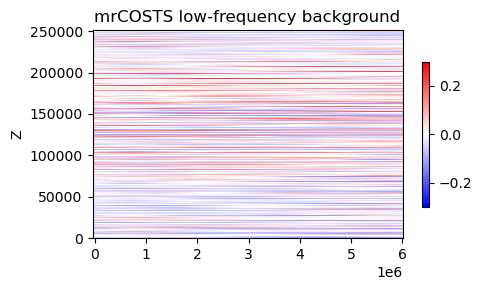

In [21]:
xr_background = dmd.get_background()

if save:
    ds_global_background = xr.DataArray(xr_background, dims=h_stacked.T.dims,
                                        coords=h_stacked.T.coords
                                       ).unstack().chunk({'time':1,'j':-1,'i':-1})
    ds_global_background.chunk(
    #         {'lat':100, 'lon':100}
    ).to_dataset(name='background'
                ).to_zarr(op.join(ddir,
                'llc4320/mrCOSTS_h/%02dhourly/reg%02d/no-filter/%02d-recons_%02dkm/background.zarr' 
                                  % (nh, reg, len(window_lengths), fscale)),
                                  mode='w')

fig, ax = plt.subplots(figsize=(5, 3))
fig.set_tight_layout(True)
im = ax.pcolormesh(
    h_stacked.time,
    np.arange(len(h_stacked.z)), 
    xr_background, 
    vmin=-.3, vmax=.3, cmap="bwr",
    rasterized=True
)
ax.set_title("mrCOSTS low-frequency background")
ax.set_ylabel("Z")
# fig.autofmt_xdate()
fig.colorbar(im, shrink=.7)

In [22]:
xr_sep = dmd.global_scale_reconstruction()

In [23]:
if save:
    for ncl_center, cl_center in enumerate(cluster_centers_periods):
    
        ds_xr_sep = xr.DataArray(
            xr_sep.real[:, ncl_center],
            dims=["decomp_level", "z", "time"],
            coords=[
                np.arange(len(dmd.costs_array)),
                # np.arange(n_optimal),
                h_stacked.z,
                h_stacked.time,
            ],
        )
    
        for dd in ds_xr_sep.decomp_level:
            if dd == 0:
                ds_global_separation = ds_xr_sep.sel(decomp_level=dd
                                                    ).unstack().chunk({'time':1,'j':-1,'i':-1})
            else:
                ds_global_separation = xr.concat([ds_global_separation,
                                                  ds_xr_sep.sel(decomp_level=dd
                                                      ).unstack().chunk({'time':1,'j':-1,'i':-1})
                                                 ], 'decomp_level'
                                                )
        
        # ds_xr_sep.isel(decomp_level=0).sum("cluster").plot(rasterized=True)
        ds_cluster_centers = xr.DataArray(
            np.array([1 / (10 ** (cluster_centroids[ncl_center]) / (2 * np.pi)),]),
            dims=["cluster"],
            # coords=[np.arange(n_optimal)],
            coords=[np.array([ncl_center,])],
        )
        ds_cluster_centers.attrs["units"] = "s"
        ds_cluster_centers.attrs["long_name"] = "Central period of each period band"
        
        ds_global_separation = ds_global_separation.to_dataset(name="frequency_bands")
        ds_global_separation["frequency_bands"].attrs["units"] = "m"
        ds_global_separation["frequency_bands"].attrs["long_name"] = "mrCOSTS"
        
        ds_global_separation.coords["cluster_centers"] = ds_cluster_centers
    
        if ncl_center == 0:
            print(ds_global_separation)
            
        ds_global_separation.chunk(
                    # {'time':1,'decomp_level':1}
                    ).to_zarr(op.join(ddir,
        'llc4320/mrCOSTS_h/%02dhourly/reg%02d/no-filter/%02d-recons_%02dkm/cluster%02d.zarr' 
                          % (nh, reg, len(window_lengths), fscale, ncl_center)),
                          mode='w')
        print(ncl_center)

<xarray.Dataset>
Dimensions:          (j: 501, i: 501, decomp_level: 4, time: 70, cluster: 1)
Coordinates:
  * j                (j) float64 1.5e+03 1.501e+03 1.502e+03 ... 1.999e+03 2e+03
  * i                (i) int64 1400 1401 1402 1403 1404 ... 1897 1898 1899 1900
  * decomp_level     (decomp_level) int64 0 1 2 3
  * time             (time) float64 0.0 8.64e+04 ... 5.875e+06 5.962e+06
  * cluster          (cluster) int64 0
    cluster_centers  (cluster) float64 1.327e+06
Data variables:
    frequency_bands  (decomp_level, time, j, i) float64 dask.array<chunksize=(1, 1, 501, 501), meta=np.ndarray>
0
1
2
3
4
5
6
7
8
9
10
11


In [24]:
xr_global_reconstruction = dmd.global_reconstruction()
da_global_reconstruction = xr.DataArray(
    data=xr_global_reconstruction.real, 
    dims=h_stacked.T.dims,
    coords=h_stacked.T.coords
).unstack().chunk({'time':1,'j':-1,'i':-1})
da_global_reconstruction.attrs["units"] = "m"
da_global_reconstruction.attrs["long_name"] = r"HYCOM SSH"

In [25]:
if save:
    da_global_reconstruction.chunk(
        # {'lat':100, 'lon':100}
    ).to_dataset(name='SSH').to_zarr(op.join(ddir,
                        'llc4320/mrCOSTS_h/%02dhourly/reg%02d/no-filter/%02d-recons_%02dkm/Total.zarr' 
                          % (nh, reg, len(window_lengths), fscale)),
                          mode='w')

In [20]:
for i in range(12):
    if i == 0:
        dsc = xr.open_zarr(op.join(ddir,
            'llc4320/mrCOSTS_h/%02dhourly/reg%02d/%02d-recons_%02dkm/cluster%02d.zarr' 
                           % (24,reg,4,fscale,i))
                          )
    else:
        try:
            dsc = xr.concat([dsc,xr.open_zarr(op.join(ddir,
                'llc4320/mrCOSTS_h/%02dhourly/reg%02d/%02d-recons_%02dkm/cluster%02d.zarr' 
                               % (24,reg,4,fscale,i)))
                            ], 'cluster')
        except:
            pass
    
dsC = xr.open_zarr(op.join(ddir,
            'llc4320/mrCOSTS_h/%02dhourly/reg%02d/%02d-recons_%02dkm/Total.zarr' 
                           % (24,reg,4,fscale))
                  )
dsc

<xarray.Dataset>
Dimensions:          (cluster: 12, decomp_level: 4, time: 70, j: 501, i: 501)
Coordinates:
  * cluster          (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11
    cluster_centers  (cluster) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * decomp_level     (decomp_level) int64 0 1 2 3
  * i                (i) int64 1400 1401 1402 1403 1404 ... 1897 1898 1899 1900
  * j                (j) float64 1.5e+03 1.501e+03 1.502e+03 ... 1.999e+03 2e+03
  * time             (time) float64 0.0 8.64e+04 ... 5.875e+06 5.962e+06
Data variables:
    frequency_bands  (cluster, decomp_level, time, j, i) float64 dask.array<chunksize=(1, 1, 1, 501, 501), meta=np.ndarray>

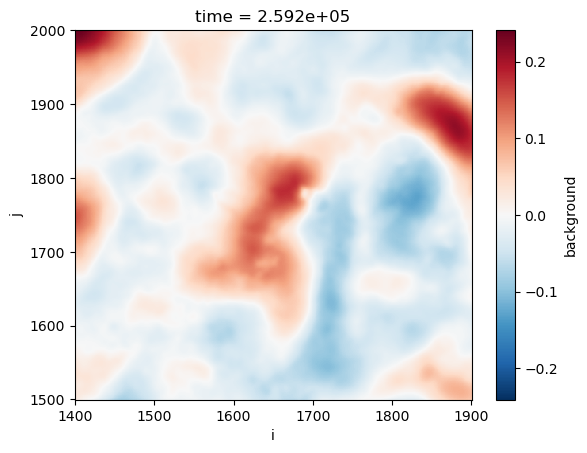

In [21]:
bg = xr.open_zarr(op.join(ddir,
            'llc4320/mrCOSTS_h/%02dhourly/reg%02d/%02d-recons_%02dkm/background.zarr' 
                          % (24,reg,4,fscale))
                 ).background

for tt in np.arange(0,len(dsc.time)-6,100):
    bg.isel(time=slice(3,-3)).isel(time=tt).plot(rasterized=True)
    plt.show()

In [22]:
n24 = -7
tt = 4
low = (xr.concat([dsc.frequency_bands.isel(cluster=slice(None,n24)),
                  # dsc.frequency_bands.isel(cluster=slice(-2,None))
                 ], 'cluster'
                    # decomp_level=slice(1,None)
                ).sum(['decomp_level','cluster']) 
       + bg).isel(time=slice(tt,-tt))
low

<xarray.DataArray (time: 62, j: 501, i: 501)>
dask.array<getitem, shape=(62, 501, 501), dtype=float64, chunksize=(1, 501, 501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1400 1401 1402 1403 1404 ... 1896 1897 1898 1899 1900
  * j        (j) float64 1.5e+03 1.501e+03 1.502e+03 ... 1.999e+03 2e+03
  * time     (time) float64 3.456e+05 4.32e+05 5.184e+05 ... 5.53e+06 5.616e+06

In [23]:
mrSSH = (xr.concat([dsc.frequency_bands.isel(cluster=slice(None,n24)),
                  # dsc.frequency_bands.isel(cluster=slice(-2,None))
                   ], 'cluster'
                        # decomp_level=slice(1,None)
                  ).sum(['decomp_level','cluster']) 
         + bg
        ).copy()
hSSH = (xr.concat([dsc.frequency_bands.isel(cluster=slice(n24,None)),
                  # dsc.frequency_bands.isel(cluster=slice(-2,None))
                   ], 'cluster'
                        # decomp_level=slice(1,None)
                  ).sum(['decomp_level','cluster']) 
        ).copy()
mrSSH

<xarray.DataArray (time: 70, j: 501, i: 501)>
dask.array<add, shape=(70, 501, 501), dtype=float64, chunksize=(1, 501, 501), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1400 1401 1402 1403 1404 ... 1896 1897 1898 1899 1900
  * j        (j) float64 1.5e+03 1.501e+03 1.502e+03 ... 1.999e+03 2e+03
  * time     (time) float64 0.0 8.64e+04 1.728e+05 ... 5.875e+06 5.962e+06

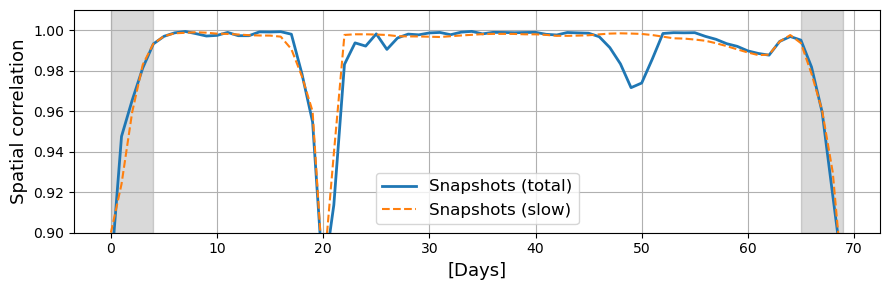

In [48]:
rcoDMD = xr.corr(ssha_m, 
                 xr.DataArray(dsC.SSH.data, dims=ssha.dims), 
                 dim=['j','i'])
rcoDMD_slow = xr.corr(ssha_m, 
                      xr.DataArray(mrSSH.data, dims=ssha.dims), 
                   dim=['j','i'])

ymin = .9
ymax = 1.01
fig, ax = plt.subplots(figsize=(9,3))
fig.set_tight_layout(True)

ax.fill_between(np.array([0, tt]), 
                ymin, ymax, color='k', alpha=.15)
ax.fill_between(np.array([69-tt,69]), 
                ymin, ymax, color='k', alpha=.15)
ax.plot(range(70), rcoDMD, lw=2,
        label=r"Snapshots (total)")
ax.plot(range(70), rcoDMD_slow, ls='--', 
        label=r"Snapshots (slow)")

ax.legend(loc='lower center', fontsize=12)
ax.set_ylim([ymin,ymax])
ax.set_ylabel(r"Spatial correlation", fontsize=13)
ax.set_xlabel(r"[Days]", fontsize=13)
ax.grid(True)
plt.savefig(op.join(ddir,'Figs/llc4320_mrCOSTS_correlation_reg%02d.pdf' % reg))

In [81]:
sshf = xr.DataArray(data=ds0.ssh_filtered.isel(time=slice(tt,-tt)
                                              ).sel(j=slice(jjs,jje),
                                                    i=slice(iis,iie)
                       ).interpolate_na(dim='i'
                                       ).interpolate_na(dim='j'
                                                       ).transpose('time','j','i'),
                    dims=ssha.dims, 
                    coords=ssha.isel(time=slice(tt,-tt)).coords
                   )
sshf -= sshf.mean(['j','i'])

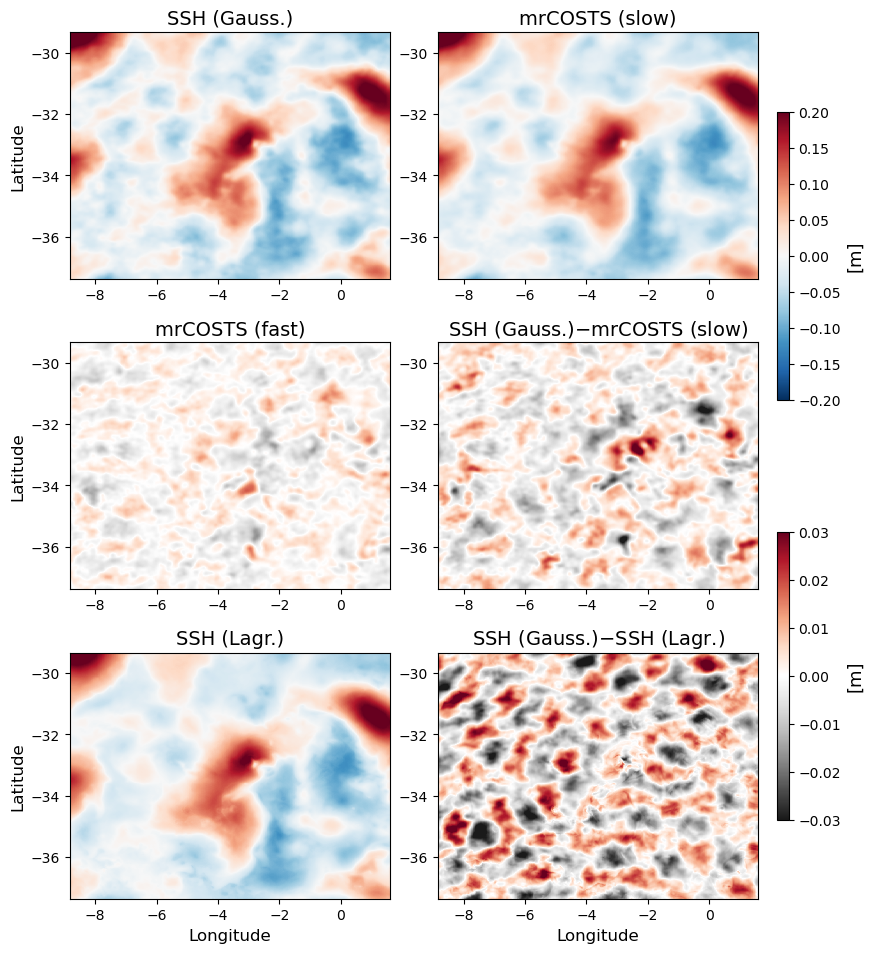

In [87]:
fig, axes = plt.subplots(figsize=(9.5,12), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                           ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                           ssha_m.isel(time=tt), 
                           rasterized=True, vmax=.2, vmin=-.2, cmap='RdBu_r')
axes[1,0].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                     ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                     hSSH.isel(time=0).real, rasterized=True, 
                     vmax=.03, vmin=-.03, cmap='RdGy_r')
axes[0,1].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                     ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                     low.isel(time=0).real, rasterized=True, 
                     vmax=.2, vmin=-.2, cmap='RdBu_r')
im1 = axes[1,1].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                           ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                           (ssha_m.isel(time=tt) - low.isel(time=0).real.data), 
                           rasterized=True,
                           cmap='RdGy_r', vmax=.03, vmin=-.03)
axes[2,0].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                     ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                     sshf.isel(time=0).sel(j=slice(jjs,jje),
                                           i=slice(iis,iie)), 
                     rasterized=True, 
                     vmax=.2, vmin=-.2, cmap='RdBu_r')
axes[2,1].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                     ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                     (-sshf.isel(time=0).sel(j=slice(jjs,jje),
                                             i=slice(iis,iie))
                      + ssha_m.isel(time=tt)), 
                     rasterized=True, 
                     vmax=.03, vmin=-.03, cmap='RdGy_r')


axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_title(r"SSH (Gauss.)", fontsize=14)
axes[0,1].set_title(r"mrCOSTS (slow)", fontsize=14)
axes[1,0].set_title(r"mrCOSTS (fast)", fontsize=14)
axes[1,1].set_title(r"SSH (Gauss.)$-$mrCOSTS (slow)", fontsize=14)
axes[2,0].set_title(r"SSH (Lagr.)", fontsize=14)
axes[2,1].set_title(r"SSH (Gauss.)$-$SSH (Lagr.)", fontsize=14)

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_xlabel(r"Longitude", fontsize=12)
axes[2,1].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(right=.85, hspace=.02, wspace=.15)
cbax0 = fig.add_axes([0.87, 0.55, 0.012, 0.24])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
cbar0.set_label(r"[m]", fontsize=13)

cbax1 = fig.add_axes([0.87, 0.2, 0.012, 0.24])
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbax1)
cbar1.set_label(r"[m]", fontsize=13)

plt.savefig(op.join(ddir,'Figs/llc4320_mrCOSTS_reg%02d.pdf' % reg))

In [59]:
grav= 9.807

coords = {'X': {'left': 'i_g', 'center': 'i'},
          'Y': {'left': 'j_g', 'center': 'j'},}
grid = Grid(ds.sel(j=slice(jjs,jje),
                   i=slice(iis,iie),
                   j_g=slice(jjs,jje),
                   i_g=slice(iis,iie)
                  ).isel(time=slice(tt,-tt)),
            coords=coords,
            periodic=[]
           )

import gsw
llcf_g = xr.apply_ufunc(gsw.f, 
                       ds.YG.sel(j_g=slice(jjs,jje),
                                 i_g=slice(iis,iie)), 
                       dask='parallelized'
                      )
llcf_j = xr.apply_ufunc(gsw.f, 
                       grid.interp(ds.YG.sel(j_g=slice(jjs,jje),
                                 i_g=slice(iis,iie)),
                                   'X',boundary='extend'), 
                       dask='parallelized'
                      )
llcf_i = xr.apply_ufunc(gsw.f, 
                       grid.interp(ds.YG.sel(j_g=slice(jjs,jje),
                                 i_g=slice(iis,iie)),
                                   'Y',boundary='extend'), 
                       dask='parallelized'
                      )
llcf = xr.apply_ufunc(gsw.f, 
                      ds.YC.sel(j=slice(jjs,jje),
                                i=slice(iis,iie)), 
                      dask='parallelized'
                     )

u_slow = -(grid.diff(low,'Y',boundary='extend')
      / ds.DYC.sel(i=slice(iis,iie),j_g=slice(jjs,jje))
     ) * grav / llcf_j
v_slow = (grid.diff(low,'X',boundary='extend')
      / ds.DXC.sel(i_g=slice(iis,iie),j=slice(jjs,jje))
     ) * grav / llcf_i
v_slow_x = grid.diff(v_slow*ds.DYG.sel(i_g=slice(iis,iie),j=slice(jjs,jje)),
                'X',boundary='extend'
               ) / ds.RAC.sel(i=slice(iis,iie),j=slice(jjs,jje))
u_slow_y = grid.diff(u_slow*ds.DXG.sel(i=slice(iis,iie),j_g=slice(jjs,jje)),
                'Y',boundary='extend'
               ) / ds.RAC.sel(i=slice(iis,iie),j=slice(jjs,jje))
vort_slow = (v_slow_x - u_slow_y) 

u = -(grid.diff(ssha_m.isel(time=slice(tt,-tt)),'Y',boundary='extend')
      / ds.DYC.sel(i=slice(iis,iie),j_g=slice(jjs,jje))
     ) * grav / llcf_j
v = (grid.diff(ssha_m.isel(time=slice(tt,-tt)),'X',boundary='extend')
     / ds.DXC.sel(i_g=slice(iis,iie),j=slice(jjs,jje))
    ) * grav / llcf_i
v_x = grid.diff(v*ds.DYG.sel(i_g=slice(iis,iie),j=slice(jjs,jje)),
                'X',boundary='extend'
               ) / ds.RAC.sel(i=slice(iis,iie),j=slice(jjs,jje))
u_y = grid.diff(u*ds.DXG.sel(i=slice(iis,iie),j_g=slice(jjs,jje)),
                'Y',boundary='extend'
               ) / ds.RAC.sel(i=slice(iis,iie),j=slice(jjs,jje))
vort = (v_x - u_y) 

u_filt = -(grid.diff(sshf,'Y',boundary='extend')
      / ds.DYC.sel(i=slice(iis,iie),j_g=slice(jjs,jje))
     ) * grav / llcf_j
v_filt = (grid.diff(sshf,'X',boundary='extend')
     / ds.DXC.sel(i_g=slice(iis,iie),j=slice(jjs,jje))
    ) * grav / llcf_i
v_filt_x = grid.diff(v_filt*ds.DYG.sel(i_g=slice(iis,iie),j=slice(jjs,jje)),
                'X',boundary='extend'
               ) / ds.RAC.sel(i=slice(iis,iie),j=slice(jjs,jje))
u_filt_y = grid.diff(u_filt*ds.DXG.sel(i=slice(iis,iie),j_g=slice(jjs,jje)),
                'Y',boundary='extend'
               ) / ds.RAC.sel(i=slice(iis,iie),j=slice(jjs,jje))
vort_filt = (v_filt_x - u_filt_y) 
vort

<xarray.DataArray (time: 62, j: 501, i: 501)>
dask.array<sub, shape=(62, 501, 501), dtype=float64, chunksize=(1, 501, 501), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time     (time) timedelta64[ns] 8 days 18:00:00 ... 69 days 18:00:00
  * i        (i) int64 1400 1401 1402 1403 1404 ... 1896 1897 1898 1899 1900
  * j        (j) float64 1.5e+03 1.501e+03 1.502e+03 ... 1.999e+03 2e+03
    x0       (i) float64 dask.array<chunksize=(501,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(501,), meta=np.ndarray>
    z0       float64 -0.5
    ...       ...
    y        (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    k        int64 0
    Depth    (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    RAC      (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>

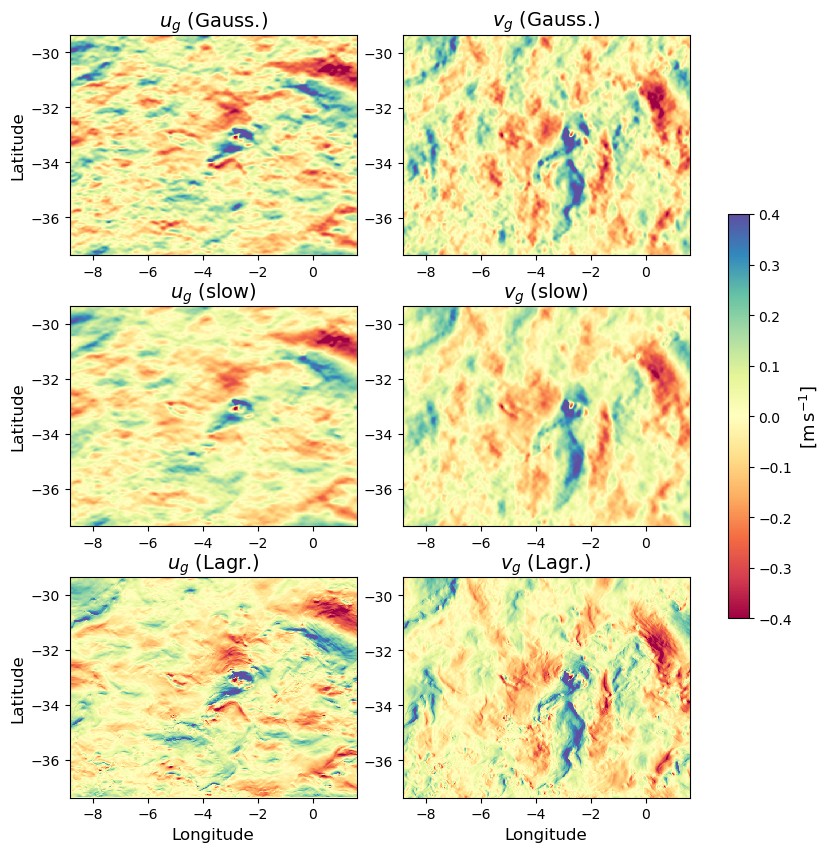

In [60]:
fig, axes = plt.subplots(figsize=(10,10.5), nrows=3, ncols=2)
# fig.set_tight_layout(True)

im0 = axes[0,0].pcolormesh(grid.interp(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                                       'Y',boundary='extend'), 
                         grid.interp(ds.YG.sel(j_g=slice(jjs,jje),i_g=slice(iis,iie)),
                                     'X',boundary='extend'),
                         u.isel(time=0), 
                         rasterized=True,
                         cmap='Spectral', vmax=.4, vmin=-.4)
axes[0,1].pcolormesh(grid.interp(ds.XG.sel(j_g=slice(jjs,jje),i_g=slice(iis,iie)),
                                 'Y',boundary='extend'), 
                   grid.interp(ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                               'X',boundary='extend'),
                   v.isel(time=0), 
                   rasterized=True,
                   cmap='Spectral', vmax=.4, vmin=-.4)
axes[1,0].pcolormesh(grid.interp(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                                       'Y',boundary='extend'), 
                         grid.interp(ds.YG.sel(j_g=slice(jjs,jje),i_g=slice(iis,iie)),
                                     'X',boundary='extend'),
                     u_slow.isel(time=0), 
                     rasterized=True,
                     cmap='Spectral', vmax=.4, vmin=-.4)
axes[1,1].pcolormesh(grid.interp(ds.XG.sel(j_g=slice(jjs,jje),i_g=slice(iis,iie)),
                                 'Y',boundary='extend'), 
                   grid.interp(ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                               'X',boundary='extend'),
                   v_slow.isel(time=0), 
                   rasterized=True,
                   cmap='Spectral', vmax=.4, vmin=-.4)
axes[2,0].pcolormesh(grid.interp(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                                       'Y',boundary='extend'), 
                         grid.interp(ds.YG.sel(j_g=slice(jjs,jje),i_g=slice(iis,iie)),
                                     'X',boundary='extend'),
                     u_filt.isel(time=0), 
                     rasterized=True,
                     cmap='Spectral', vmax=.4, vmin=-.4)
axes[2,1].pcolormesh(grid.interp(ds.XG.sel(j_g=slice(jjs,jje),i_g=slice(iis,iie)),
                                 'Y',boundary='extend'), 
                   grid.interp(ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                               'X',boundary='extend'),
                   v_filt.isel(time=0), 
                   rasterized=True,
                   cmap='Spectral', vmax=.4, vmin=-.4)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
axes[2,0].set_aspect('equal')
axes[2,1].set_aspect('equal')

axes[0,0].set_title(r"$u_g$ (Gauss.)", fontsize=14)
axes[0,1].set_title(r"$v_g$ (Gauss.)", fontsize=14)
axes[1,0].set_title(r"$u_g$ (slow)", fontsize=14)
axes[1,1].set_title(r"$v_g$ (slow)", fontsize=14)
axes[2,0].set_title(r"$u_g$ (Lagr.)", fontsize=14)
axes[2,1].set_title(r"$v_g$ (Lagr.)", fontsize=14)

axes[0,0].set_ylabel(r"Latitude", fontsize=12)
axes[1,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_ylabel(r"Latitude", fontsize=12)
axes[2,0].set_xlabel(r"Longitude", fontsize=12)
axes[2,1].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(right=.9, hspace=.02, wspace=.16)
cbar0 = fig.colorbar(im0, ax=axes, shrink=.5)
cbar0.set_label(r"[m$\,$s$^{-1}$]", fontsize=13)

plt.savefig(op.join(ddir,'Figs/llc4320-UV_mrCOSTS_reg%02d.pdf' % reg))

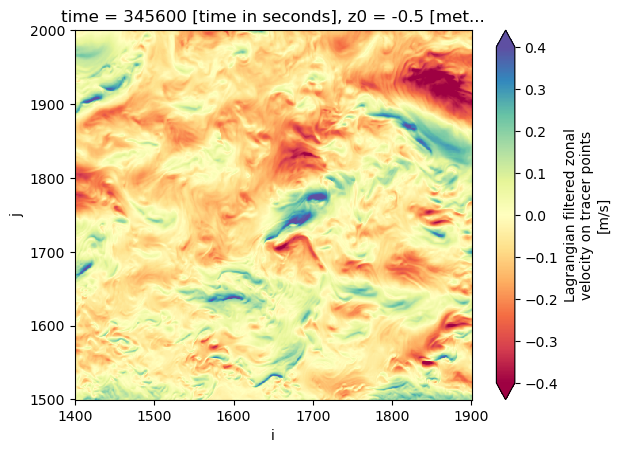

In [69]:
ds0.u_filtered.isel(time=tt).sel(j=slice(jjs,jje),i=slice(iis,iie)).T.plot(
                   cmap='Spectral', vmin=-.4, vmax=.4, rasterized=True)

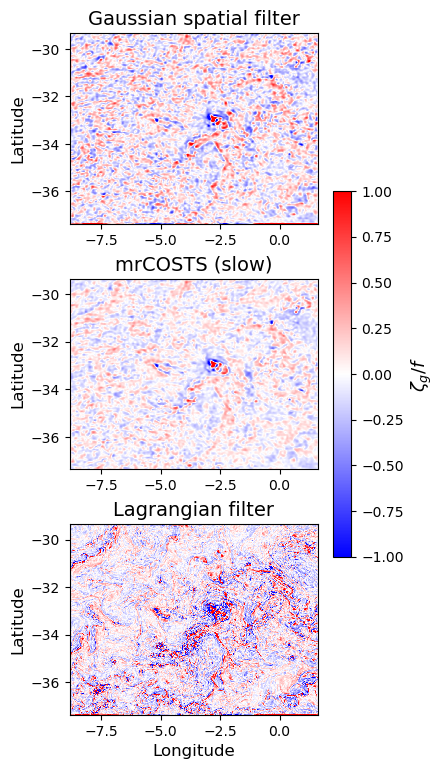

In [62]:
fig, axes = plt.subplots(figsize=(4,9.5), nrows=3, ncols=1)
# fig.set_tight_layout(True)

im0 = axes[0].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                         ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                         vort.isel(time=0)/llcf, 
                         rasterized=True,
                         cmap='bwr', vmax=1., vmin=-1.)
axes[1].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                   ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                   vort_slow.isel(time=0)/llcf, 
                   rasterized=True,
                   cmap='bwr', vmax=1., vmin=-1.)
axes[2].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                   ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                   vort_filt.isel(time=0)/llcf, 
                   rasterized=True,
                   cmap='bwr', vmax=1., vmin=-1.)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

axes[0].set_title(r"Gaussian spatial filter", fontsize=14)
axes[1].set_title(r"mrCOSTS (slow)", fontsize=14)
axes[2].set_title(r"Lagrangian filter", fontsize=14)

axes[0].set_ylabel(r"Latitude", fontsize=12)
axes[1].set_ylabel(r"Latitude", fontsize=12)
axes[2].set_ylabel(r"Latitude", fontsize=12)
axes[2].set_xlabel(r"Longitude", fontsize=12)


fig.subplots_adjust(right=.9, hspace=.02, wspace=.16)
cbar0 = fig.colorbar(im0, ax=axes, shrink=.5)
cbar0.set_label(r"$\zeta_g/f$", fontsize=13)

plt.savefig(op.join(ddir,'Figs/llc4320-vort_mrCOSTS_reg%02d.pdf' % reg))

In [70]:
u_x = grid.diff(u*ds.DYC.sel(j_g=slice(jjs,jje),i=slice(iis,iie)),
                'X',boundary='extend'
               ) / grid.interp(grid.interp(ds.RAC.sel(j=slice(jjs,jje),
                                                      i=slice(iis,iie)),
                                           'X',boundary='extend'),
                               'Y',boundary='extend'
                              )
v_y = grid.diff(v*ds.DXC.sel(j=slice(jjs,jje),i_g=slice(iis,iie)),
                'Y',boundary='extend'
               ) / grid.interp(grid.interp(ds.RAC.sel(j=slice(jjs,jje),
                                                      i=slice(iis,iie)),
                                           'X',boundary='extend'),
                               'Y',boundary='extend'
                              )

sn = grid.interp(grid.interp(u_x - v_y,
                             'X',boundary='extend'),
                 'Y',boundary='extend'
                ) 
ss = (v_x + u_y) 
strain = np.sqrt(sn**2 + ss**2)

u_slow_x = grid.diff(u_slow*ds.DYC.sel(j_g=slice(jjs,jje),i=slice(iis,iie)),
                'X',boundary='extend'
               ) / grid.interp(grid.interp(ds.RAC.sel(j=slice(jjs,jje),
                                                      i=slice(iis,iie)),
                                           'X',boundary='extend'),
                               'Y',boundary='extend'
                              )
v_slow_y = grid.diff(v_slow*ds.DXC.sel(j=slice(jjs,jje),i_g=slice(iis,iie)),
                'Y',boundary='extend'
               ) / grid.interp(grid.interp(ds.RAC.sel(j=slice(jjs,jje),
                                                      i=slice(iis,iie)),
                                           'X',boundary='extend'),
                               'Y',boundary='extend'
                              )

sn = grid.interp(grid.interp(u_slow_x - v_slow_y,
                             'X',boundary='extend'),
                 'Y',boundary='extend'
                ) 
ss = (v_x + u_y) 
strain_slow = np.sqrt(sn**2 + ss**2) 

u_filt_x = grid.diff(u_filt*ds.DYC.sel(j_g=slice(jjs,jje),i=slice(iis,iie)),
                'X',boundary='extend'
               ) / grid.interp(grid.interp(ds.RAC.sel(j=slice(jjs,jje),
                                                      i=slice(iis,iie)),
                                           'X',boundary='extend'),
                               'Y',boundary='extend'
                              )
v_filt_y = grid.diff(v_filt*ds.DXC.sel(j=slice(jjs,jje),i_g=slice(iis,iie)),
                'Y',boundary='extend'
               ) / grid.interp(grid.interp(ds.RAC.sel(j=slice(jjs,jje),
                                                      i=slice(iis,iie)),
                                           'X',boundary='extend'),
                               'Y',boundary='extend'
                              )

sn = grid.interp(grid.interp(u_filt_x - v_filt_y,
                             'X',boundary='extend'),
                 'Y',boundary='extend'
                )  
ss = (v_x + u_y) 
strain_filt = np.sqrt(sn**2 + ss**2) 
strain

<xarray.DataArray (time: 62, j: 501, i: 501)>
dask.array<sqrt, shape=(62, 501, 501), dtype=float64, chunksize=(1, 501, 501), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * time     (time) timedelta64[ns] 8 days 18:00:00 ... 69 days 18:00:00
  * i        (i) int64 1400 1401 1402 1403 1404 ... 1896 1897 1898 1899 1900
  * j        (j) float64 1.5e+03 1.501e+03 1.502e+03 ... 1.999e+03 2e+03
    x0       (i) float64 dask.array<chunksize=(501,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(501,), meta=np.ndarray>
    z0       float64 -0.5
    ...       ...
    y        (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    k        int64 0
    Depth    (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>
    RAC      (j, i) float32 dask.array<chunksize=(501, 501), meta=np.ndarray>

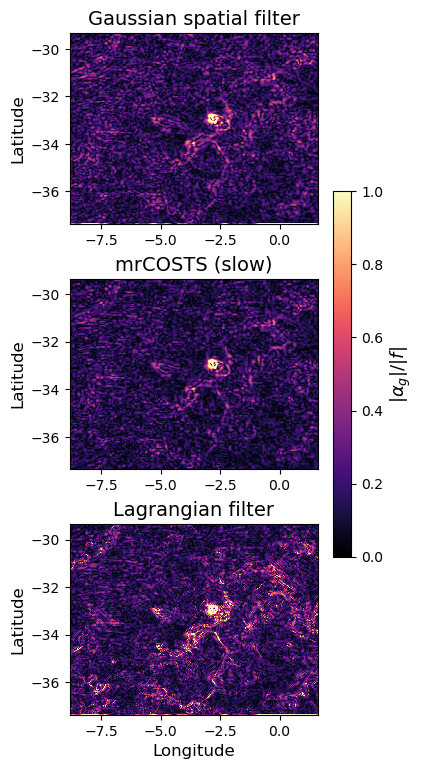

In [71]:
fig, axes = plt.subplots(figsize=(4,9.5), nrows=3, ncols=1)
# fig.set_tight_layout(True)

im0 = axes[0].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                         ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                         strain.isel(time=0)/np.abs(llcf), 
                         rasterized=True,
                         cmap='magma', vmax=1., vmin=0)
axes[1].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                   ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                   strain_slow.isel(time=0)/np.abs(llcf), 
                   rasterized=True,
                   cmap='magma', vmax=1., vmin=0)
axes[2].pcolormesh(ds.XC.sel(j=slice(jjs,jje),i=slice(iis,iie)), 
                   ds.YC.sel(j=slice(jjs,jje),i=slice(iis,iie)),
                   strain_filt.isel(time=0)/np.abs(llcf), 
                   rasterized=True,
                   cmap='magma', vmax=1., vmin=0)

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')

axes[0].set_title(r"Gaussian spatial filter", fontsize=14)
axes[1].set_title(r"mrCOSTS (slow)", fontsize=14)
axes[2].set_title(r"Lagrangian filter", fontsize=14)

axes[0].set_ylabel(r"Latitude", fontsize=12)
axes[1].set_ylabel(r"Latitude", fontsize=12)
axes[2].set_ylabel(r"Latitude", fontsize=12)
axes[2].set_xlabel(r"Longitude", fontsize=12)

fig.subplots_adjust(right=.9, hspace=.02, wspace=.16)
cbar0 = fig.colorbar(im0, ax=axes, shrink=.5)
cbar0.set_label(r"$|\alpha_g|/|f|$", fontsize=13)

plt.savefig(op.join(ddir,'Figs/llc4320-str_mrCOSTS_reg%02d.pdf' % reg))

In [72]:
vbins = np.linspace(-4e0,4e0,60)
sbins = np.linspace(0,4e0,30)
hist_g = xhist((strain / np.abs(llcf)
               ).isel(j=slice(1,-1),i=slice(1,-1)
                     ).rename('strain'
                             ).chunk({'time':10,'j':-1,'i':-1}), 
               (vort / llcf
               ).isel(j=slice(1,-1),i=slice(1,-1)
                     ).rename('vort'
                             ).chunk({'time':10,'j':-1,'i':-1}), 
               bins=[sbins, vbins], density=True
              ).compute()
hist_m = xhist((strain_slow / np.abs(llcf)
               ).isel(j=slice(1,-1),i=slice(1,-1)
                     ).rename('strain'
                             ).chunk({'time':10,'j':-1,'i':-1}), 
               (vort_slow / llcf
               ).isel(j=slice(1,-1),i=slice(1,-1)
                     ).rename('vort'
                             ).chunk({'time':10,'j':-1,'i':-1}), 
               bins=[sbins, vbins], density=True
              ).compute()
hist_l = xhist((strain_filt / np.abs(llcf)
               ).isel(j=slice(1,-1),i=slice(1,-1)
                     ).rename('strain'
                             ).chunk({'time':10,'j':-1,'i':-1}), 
               (vort_filt / llcf
               ).isel(j=slice(1,-1),i=slice(1,-1)
                     ).rename('vort'
                             ).chunk({'time':10,'j':-1,'i':-1}), 
               bins=[sbins, vbins], density=True
              ).compute()

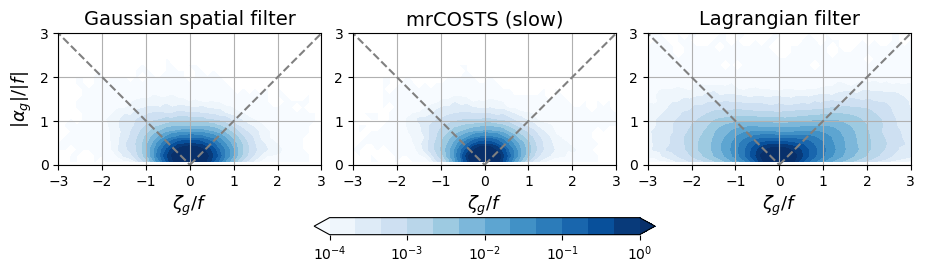

In [73]:
fig, axes = plt.subplots(figsize=(11,4.4), nrows=1, ncols=3)
# fig.set_tight_layout(True)

im0 = axes[0].contourf(hist_g.vort_bin,
                 hist_g.strain_bin,
                 hist_g, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,13),
                 extend='both'
#                       rasterized=True
               )
im1 = axes[1].contourf(hist_m.vort_bin,
                 hist_m.strain_bin,
                 hist_m, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,13),
                 extend='both'
#                       rasterized=True
               )
im2 = axes[2].contourf(hist_l.vort_bin,
                 hist_l.strain_bin,
                 hist_l, 
                 cmap='Blues', locator=ticker.LogLocator(), 
                 norm=clr.LogNorm(), levels=np.logspace(-4,0,13),
                 extend='both'
#                       rasterized=True
               )

for c in im0.collections:
    c.set_rasterized(True)
for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)

axes[0].plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
axes[0].plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
axes[1].plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
axes[1].plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
axes[2].plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
axes[2].plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')

axes[0].set_xlim([-3,3])
axes[0].set_ylim([0,3])
axes[1].set_xlim([-3,3])
axes[1].set_ylim([0,3])
axes[2].set_xlim([-3,3])
axes[2].set_ylim([0,3])

axes[0].set_title(r"Gaussian spatial filter", fontsize=14)
axes[1].set_title(r"mrCOSTS (slow)", fontsize=14)
axes[2].set_title(r"Lagrangian filter", fontsize=14)

axes[0].set_xlabel(r"$\zeta_g/f$", fontsize=13)
axes[0].set_ylabel(r"$|\alpha_g|/|f|$", fontsize=13)
axes[1].set_xlabel(r"$\zeta_g/f$", fontsize=13)
axes[2].set_xlabel(r"$\zeta_g/f$", fontsize=13)

axes[0].grid(True)
axes[0].set_aspect('equal')
axes[1].grid(True)
axes[1].set_aspect('equal')
axes[2].grid(True)
axes[2].set_aspect('equal')

fig.subplots_adjust(bottom=.08, hspace=.06, wspace=.12)
cbar = fig.colorbar(im0, orientation='horizontal', ax=axes, shrink=.4, 
                    ticks=[1e-4,1e-3,1e-2,1e-1,1e0])

# plt.savefig(op.join(sdir,'Figs/vort-strain-SWOTjointPDF.pdf'))